# Parkinson's Disease Detector with Apache Cassandra and PySpark Machine Learning

#### Jupyter notebook inspired by the template at https://github.com/datastaxdevs/workshop-machine-learning/blob/master/jupyter/Random%20Forest.ipynb

In [1]:
!pip install cassandra-driver --quiet
!pip install matplotlib --quiet
!pip install ipykernel --quiet
!pip install scikit-learn --quiet
!python3 -m ipykernel install --user --name=vs-l-pd-detector

!PYDEVD_DISABLE_FILE_VALIDATION=1

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Installed kernelspec vs-l-pd-detector in /Users/mariannelynemanaog/Library/Jupyter/kernels/vs-l-pd-detector


In [2]:
import os
import random
import re
import warnings

import cassandra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display, Markdown
from random import randint, randrange

from cassandra.cluster import Cluster
from cassandra.policies import DCAwareRoundRobinPolicy

from scipy import stats

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

import sys
sys.path.append('../')
from src.analyse_data.visualise_multi_collinear_feats import plot_multi_collinearity_heatmap
from src.create_cassandra_db.create_tables import create_table, write_data_to_table
from src.create_cassandra_db.utils import create_and_set_keyspace, create_session, get_all_data_from_table
from src.process_data.balance_classes import balance_samples_per_class
from src.process_data.remove_outliers import z_score_outlier_removal

warnings.filterwarnings('ignore')
%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Set up Apache Cassandra

In [3]:
# Install the latest version of Cassandra (4.1.3) from https://www.apache.org/dyn/closer.lua/cassandra/4.1.3/apache-cassandra-4.1.3-bin.tar.gz

In [4]:
# Install GPG to verify the hash of the downloaded tarball
!arch -arm64 brew install gnupg gnupg2

# Link GPG
!brew link gnupg

# !gpg --print-md SHA256 apache-cassandra-4.1.3-bin.tar.gz

# Compare the signature with the SHA256 file from the Downloads site
# !curl -L https://downloads.apache.org/cassandra/4.1.3/apache-cassandra-4.1.3-bin.tar.gz.sha256

# Unpack the tarball (when done the first time)
# !tar xzvf apache-cassandra-4.1.3-bin.tar.gz

# os.chdir('apache-cassandra-4.1.3')

!bin/cassandra

# Verify cassandra installation by checking its version number
!cassandra -v

# Start the cassandra server on the terminal
# !cassandra -f

==> Downloading https://formulae.brew.sh/api/formula.jws.json
######################################################################### 100.0%
==> Downloading https://formulae.brew.sh/api/cask.jws.json
######################################################################### 100.0%
To reinstall 2.4.3, run:
  brew reinstall gnupg
To relink, run:
  brew unlink gnupg && brew link gnupg
zsh:1: no such file or directory: bin/cassandra
4.1.3


## Creating and loading tables

### Connect to Cassandra

In [5]:
session = create_session()

INFO:cassandra.policies:Using datacenter 'datacenter1' for DCAwareRoundRobinPolicy (via host '127.0.0.1:9042'); if incorrect, please specify a local_dc to the constructor, or limit contact points to local cluster nodes


### Create and set keyspace 

In [6]:
create_and_set_keyspace(session)

### Create two tables called `speech_data_train` and `speech_data_test` containing the train and test sets respectively. The PRIMARY will be a unique key (subject_id) for each row.

In [7]:
create_table(session, 'speech_data_train')

In [8]:
create_table(session, 'speech_data_test')

### Load the train and test datasets from csv files

#### Insert train and test speech data into the tables `speech_data_train` and `speech_data_test` respectively

In [9]:
write_data_to_table(
    session,
    '/Users/mariannelynemanaog/PycharmProjects/vs-ml-pd-detector/src/data/train_and_test_sets/train_data.csv',
    'speech_data_train'
)

write_data_to_table(
    session,
    '/Users/mariannelynemanaog/PycharmProjects/vs-ml-pd-detector/src/data/train_and_test_sets/test_data.csv',
    'speech_data_test'
)

## Machine Learning with Apache Cassandra and sklearn

In [10]:
df_train = get_all_data_from_table(session, 'speech_data_train')
df_test = get_all_data_from_table(session, 'speech_data_test')

#### Identify and remove multi-collinear features

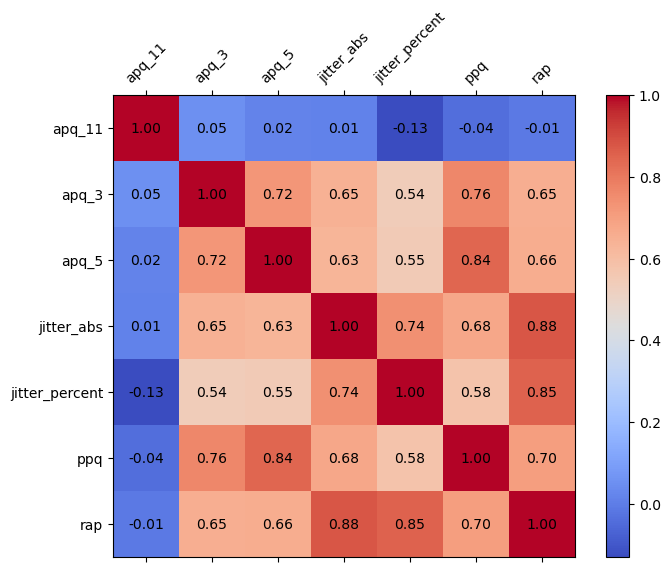

In [11]:
plot_multi_collinearity_heatmap(df_train.iloc[:, 1:8])

The features that bring unique information to discriminate between pathophysiological and healthy speech patterns 
are the following ones:
- apq11, as no other numeric features are highly correlated with it
- apq3, whilst the multi-collinear (e.g., > 0.7) apq5 and ppq are suggested to be removed since they are not adding 
any further unique information with respect to apq3
- jitter_percent, whilst the multi-collinear (e.g., > 0.7) jitter_abs and rap are suggested to be removed since they are not adding any further unique information with respect to jitter_percent.

In [12]:
unique_feats_to_retain = ['subject_id', 'apq_11', 'apq_3', 'jitter_percent', 'status']
df_train = df_train[unique_feats_to_retain]

df_train.describe()

,apq_11,apq_3,jitter_percent,status
count,1503.000000,1503.000000,1503.000000,1503.000000
mean,1.405134,8.734374,0.889277,0.596141
std,2.872461,7.265618,0.982743,0.490833
min,0.006070,0.003630,0.000005,0.000000
25%,0.682797,2.183000,0.015595,0.000000
50%,0.840368,8.649000,0.696000,1.000000
75%,0.911487,13.412000,1.299000,1.000000
max,39.007999,44.764000,8.016000,1.000000


In [13]:
df_test = df_test[unique_feats_to_retain]

df_test.describe()

,apq_11,apq_3,jitter_percent,status
count,252.000000,252.000000,252.000000,252.000000
mean,0.053749,0.034021,0.002263,0.746032
std,0.031213,0.022342,0.002632,0.436146
min,0.005220,0.003350,0.000210,0.000000
25%,0.029327,0.017240,0.000998,0.000000
50%,0.047195,0.027325,0.001440,1.000000
75%,0.071335,0.044585,0.002395,1.000000
max,0.167680,0.130510,0.027750,1.000000


#### Remove outliers from train and test sets via z-scores

In [14]:
columns_to_process = ['apq_11', 'apq_3', 'jitter_percent']

z_score_thresh_train = 3.5

df_train = z_score_outlier_removal(df_train, columns_to_process, z_score_thresh_train)

df_train.describe()

,apq_11,apq_3,jitter_percent,status
count,1446.000000,1446.000000,1446.000000,1446.000000
mean,1.104668,8.515723,0.834364,0.587828
std,1.720087,6.939063,0.792473,0.492396
min,0.006070,0.003630,0.000005,0.000000
25%,0.683534,1.892500,0.098000,0.000000
50%,0.840173,8.643000,0.701500,1.000000
75%,0.907474,13.280250,1.268750,1.000000
max,11.245000,33.550999,4.158000,1.000000


In [15]:
z_score_thresh_test = 1

df_test = z_score_outlier_removal(df_test, columns_to_process, z_score_thresh_test)

df_test.describe()

,apq_11,apq_3,jitter_percent,status
count,117.000000,117.000000,117.000000,117.000000
mean,0.043668,0.026562,0.001416,0.777778
std,0.013817,0.007969,0.000582,0.417528
min,0.022980,0.014900,0.000510,0.000000
25%,0.032480,0.020490,0.001030,1.000000
50%,0.041140,0.025030,0.001370,1.000000
75%,0.054670,0.032740,0.001800,1.000000
max,0.081370,0.044930,0.003160,1.000000


In [16]:
df_train['status'].value_counts()

status
1    850
0    596
Name: count, dtype: int64

In [17]:
df_train = balance_samples_per_class(df_train)

In [18]:
df_train['status'].value_counts()

status
0    596
1    596
Name: count, dtype: int64

In [19]:
df_test['status'].value_counts()

status
1    91
0    26
Name: count, dtype: int64

In [20]:
train_features = df_train.iloc[:, 1:4]
train_labels = df_train.iloc[:, 4]

# Create a KNeighborsClassifier with cross-validated hyperparameter tuning
knn_classifier = KNeighborsClassifier(
    weights='distance',
    n_neighbors=2,
    p=0.5,
    leaf_size=6,
    algorithm='brute'
)

param_grid = {
    'weights': ['uniform', 'distance'],
    'leaf_size': [6, 8, 12, 15, 30],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='recall')

grid_search.fit(train_features, train_labels)

best_knn_classifier = grid_search.best_estimator_

train_predictions_from_KNN = best_knn_classifier.predict(train_features)

print(classification_report(train_labels, train_predictions_from_KNN))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       596
           1       1.00      1.00      1.00       596

    accuracy                           1.00      1192
   macro avg       1.00      1.00      1.00      1192
weighted avg       1.00      1.00      1.00      1192



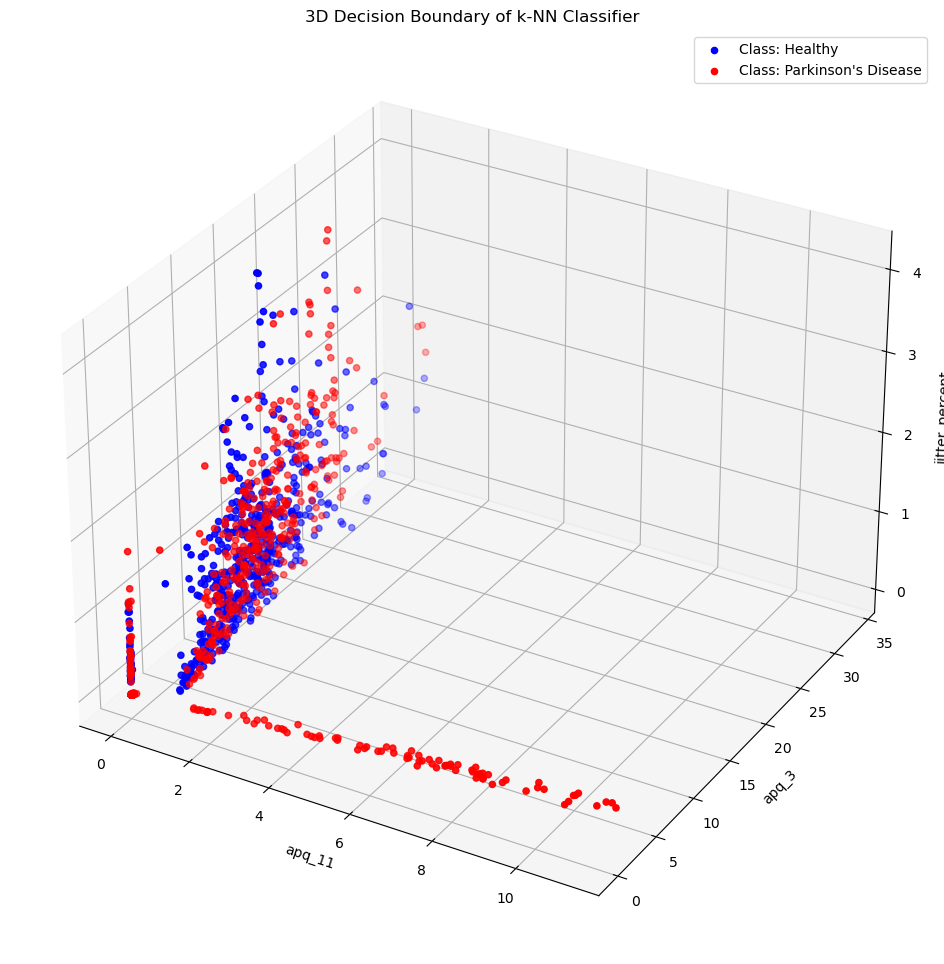

In [36]:
# Create a mesh grid of points in the feature space
x_min, x_max = train_features.iloc[:, 0].min() - 1, train_features.iloc[:, 0].max() + 1
y_min, y_max = train_features.iloc[:, 1].min() - 1, train_features.iloc[:, 1].max() + 1
z_min, z_max = train_features.iloc[:, 2].min() - 1, train_features.iloc[:, 2].max() + 1
xx, yy, zz = np.meshgrid(
    np.arange(x_min, x_max, 0.1),
    np.arange(y_min, y_max, 0.1),
    np.arange(z_min, z_max, 0.1)
)

# Predict the class labels for the mesh grid points
mesh_grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
Z = best_knn_classifier.predict(mesh_grid_points)

# Reshape Z to match the shape of xx, yy, zz
Z = Z.reshape(xx.shape)

# Create a 3D plot
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Convert labels to a NumPy array
train_labels_array = train_labels.to_numpy()

# Plot the decision boundary by plotting individual data points
for label in np.unique(train_labels_array):
    indices = train_labels_array == label
    if label == 0:
        label_text = 'Healthy'
        color = 'blue'
    else:
        label_text = "Parkinson's Disease"
        color = 'red'
    
    ax.scatter(
        train_features.iloc[indices, 0],
        train_features.iloc[indices, 1],
        train_features.iloc[indices, 2],
        label=f'Class: {label_text}',
        color=color,  # Set color based on class
    )

# Set labels and title
ax.set_xlabel(train_features.columns[0])
ax.set_ylabel(train_features.columns[1])
ax.set_zlabel(train_features.columns[2], labelpad=6)  # Adjust labelpad to display the Z-label
ax.set_title('3D Decision Boundary of k-NN Classifier')

# Show the legend
ax.legend()

plt.show()

In [22]:
train_probas_from_KNN = best_knn_classifier.predict_proba(train_features)

preds_based_on_proba = []
for test_proba in train_probas_from_KNN:
    if test_proba[1] > 0.4:
        pred = 1
    else:
        pred = 0
    preds_based_on_proba.append(pred)

print(classification_report(train_labels, preds_based_on_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       596
           1       1.00      1.00      1.00       596

    accuracy                           1.00      1192
   macro avg       1.00      1.00      1.00      1192
weighted avg       1.00      1.00      1.00      1192



In [23]:
df_train.reset_index(inplace=True)
df_train['vector_similarity'] = pd.Series(train_predictions_from_KNN)

df_train = df_train[['subject_id', 'apq_11', 'apq_3', 'jitter_percent', 'vector_similarity', 'status']]

train_features = df_train.iloc[:, 1:5]
train_labels = df_train.iloc[:, 5]

test_features = df_test.iloc[:, 1:4]
test_labels = df_test.iloc[:, 4]

test_predictions_from_KNN = best_knn_classifier.predict(test_features)
test_probabilities_from_KNN = best_knn_classifier.predict_proba(test_features)

print(classification_report(test_labels, test_predictions_from_KNN))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.78      1.00      0.88        91

    accuracy                           0.78       117
   macro avg       0.39      0.50      0.44       117
weighted avg       0.60      0.78      0.68       117



In [24]:
preds_based_on_proba = []
for test_proba in test_probabilities_from_KNN:
    if test_proba[1] > 0.7:
        pred = 1
    else:
        pred = 0
    preds_based_on_proba.append(pred)

print(classification_report(test_labels, preds_based_on_proba))

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        26
           1       0.79      1.00      0.88        91

    accuracy                           0.79       117
   macro avg       0.90      0.54      0.51       117
weighted avg       0.84      0.79      0.72       117



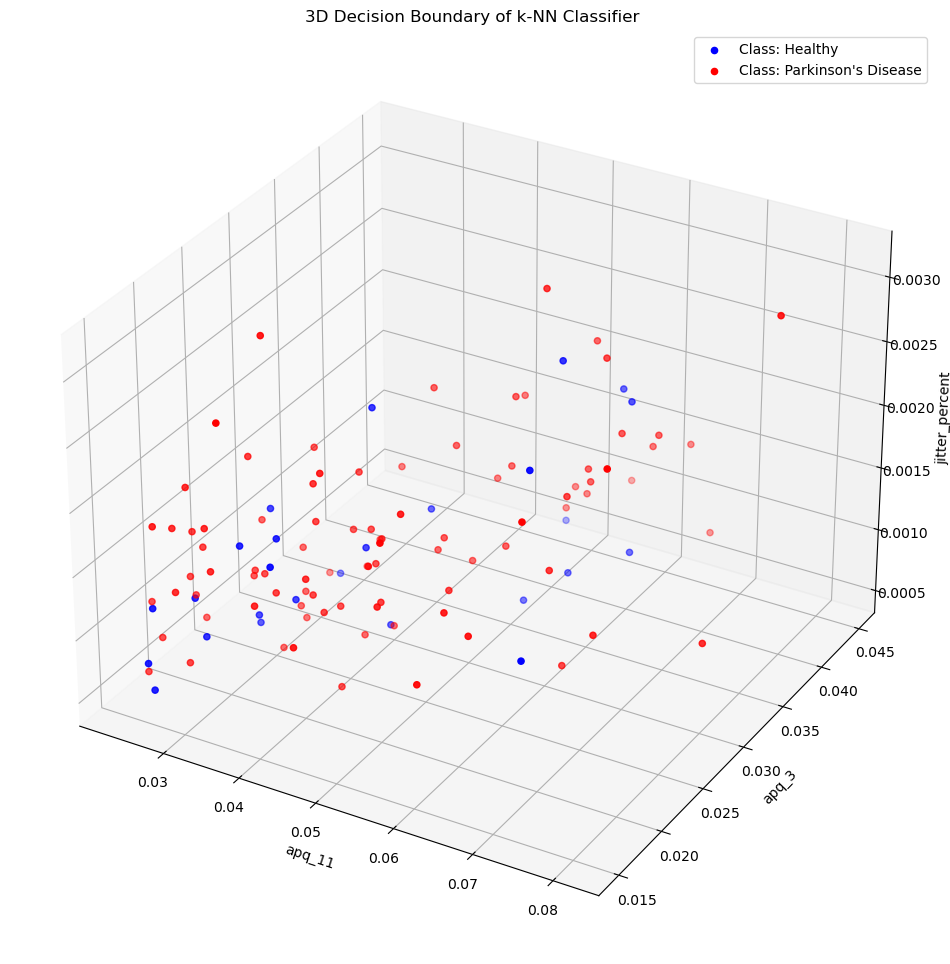

In [35]:
# Create a mesh grid of points in the feature space
x_min, x_max = test_features.iloc[:, 0].min() - 1, test_features.iloc[:, 0].max() + 1
y_min, y_max = test_features.iloc[:, 1].min() - 1, test_features.iloc[:, 1].max() + 1
z_min, z_max = test_features.iloc[:, 2].min() - 1, test_features.iloc[:, 2].max() + 1
xx, yy, zz = np.meshgrid(
    np.arange(x_min, x_max, 0.1),
    np.arange(y_min, y_max, 0.1),
    np.arange(z_min, z_max, 0.1)
)

# Predict the class labels for the mesh grid points
mesh_grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
Z = best_knn_classifier.predict(mesh_grid_points)

# Reshape Z to match the shape of xx, yy, zz
Z = Z.reshape(xx.shape)

# Create a 3D plot
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Convert labels to a NumPy array
test_labels_array = test_labels.to_numpy()

# Plot the decision boundary by plotting individual data points
for label in np.unique(test_labels_array):
    indices = test_labels_array == label
    if label == 0:
        label_text = 'Healthy'
        color = 'blue'
    else:
        label_text = "Parkinson's Disease"
        color = 'red'
    
    ax.scatter(
        test_features.iloc[indices, 0],
        test_features.iloc[indices, 1],
        test_features.iloc[indices, 2],
        label=f'Class: {label_text}',
        color=color,  # Set color based on class
    )

# Set labels and title
ax.set_xlabel(test_features.columns[0])
ax.set_ylabel(test_features.columns[1])
ax.set_zlabel(test_features.columns[2], labelpad=6)  # Adjust labelpad to display the Z-label
ax.set_title('3D Decision Boundary of k-NN Classifier')

# Show the legend
ax.legend()

plt.show()

In [26]:
df_test.reset_index(inplace=True)
df_test['vector_similarity'] = pd.Series(preds_based_on_proba)

df_test = df_test[['subject_id', 'apq_11', 'apq_3', 'jitter_percent', 'vector_similarity', 'status']]

test_features = df_test.iloc[:, 1:5]
test_labels = df_test.iloc[:, 5]

### Train a Gradient-Boosted Tree model whilst preserving the train and test sets generated above, which prevent both time-related data leakage and do not have any overlapping subjects between train and test sets.

### The optimal hyperparameters were obtained via grid search optimisation when cross-validating the model during training.

In [27]:
gbt = GradientBoostingClassifier(
    random_state=13,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=15,
    max_features='sqrt',
    subsample=0.6
)

pipeline = Pipeline(steps=[('gbt', gbt)])

param_grid = {
    'gbt__n_estimators': [10, 20, 30, 50, 100],
    'gbt__learning_rate': [0.05, 0.15, 0.2, 0.25, 0.3],
    'gbt__max_depth': [3, 4, 5, 7, 9, 12, 15],
    'gbt__n_iter_no_change': [5, 7, 9, 11, 15],
    'gbt__subsample': [0.3, 0.5, 0.7, 0.9],
    'gbt__max_leaf_nodes': [None],
}

# Create a custom scorer for weighted recall
weighted_recall_scorer = make_scorer(recall_score, average='weighted')

gbt_gridsearch = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                              cv=5, scoring=weighted_recall_scorer)

best_gbt = gbt.fit(train_features, train_labels)

predictions_from_GBT = best_gbt.predict(test_features)

print(classification_report(test_labels, predictions_from_GBT))

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        26
           1       0.79      1.00      0.88        91

    accuracy                           0.79       117
   macro avg       0.90      0.54      0.51       117
weighted avg       0.84      0.79      0.72       117



In [28]:
probas_from_GBT = best_gbt.predict_proba(test_features)

preds_based_on_proba = []
for test_proba in probas_from_GBT:
    if test_proba[1] > 0.78:
        pred = 1
    else:
        pred = 0
    preds_based_on_proba.append(pred)

print(classification_report(test_labels, preds_based_on_proba))

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        26
           1       0.79      1.00      0.88        91

    accuracy                           0.79       117
   macro avg       0.90      0.54      0.51       117
weighted avg       0.84      0.79      0.72       117



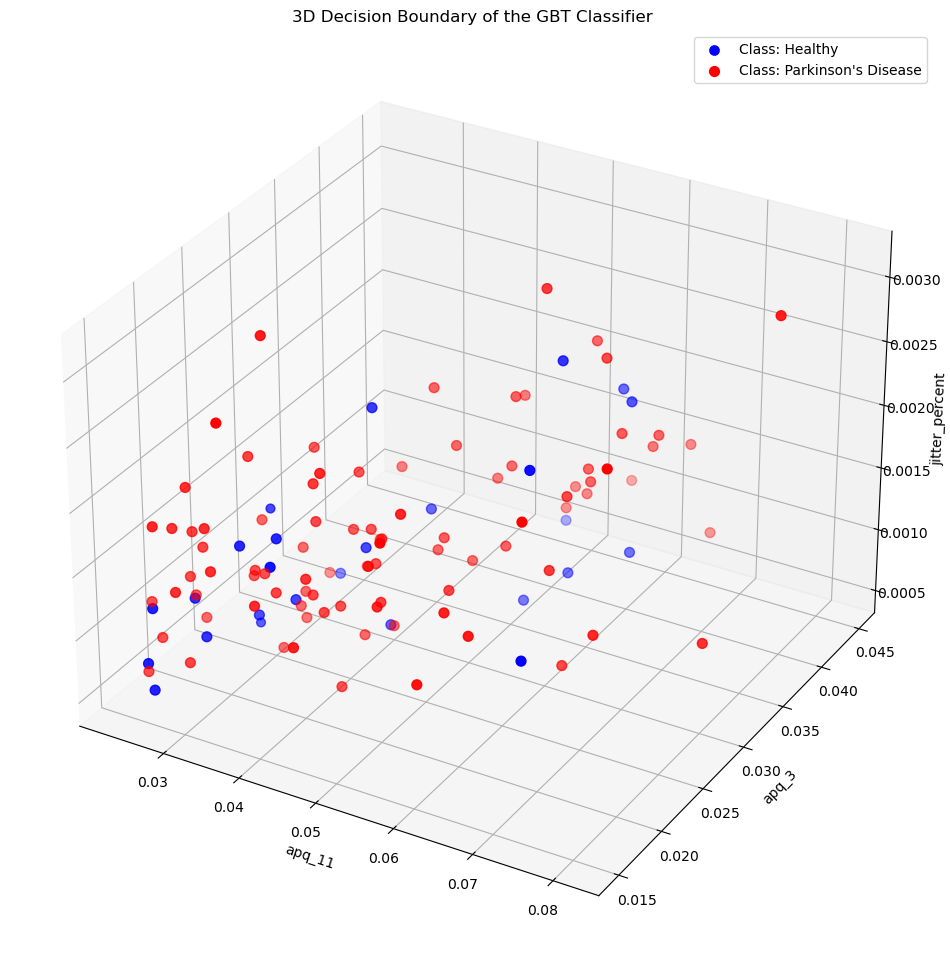

In [34]:
# Create a mesh grid of points in the feature space
x_min, x_max = test_features.iloc[:, 0].min() - 1, test_features.iloc[:, 0].max() + 1
y_min, y_max = test_features.iloc[:, 1].min() - 1, test_features.iloc[:, 1].max() + 1
z_min, z_max = test_features.iloc[:, 2].min() - 1, test_features.iloc[:, 2].max() + 1
w_min, w_max = test_features.iloc[:, 3].min() - 1, test_features.iloc[:, 3].max() + 1

xx, yy, zz, ww = np.meshgrid(
    np.arange(x_min, x_max, 0.1),
    np.arange(y_min, y_max, 0.1),
    np.arange(z_min, z_max, 0.1),
    np.arange(w_min, w_max, 0.1)
)

# Predict the class labels for the mesh grid points
mesh_grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel(), ww.ravel()]
Z = best_gbt.predict(mesh_grid_points)

# Create a 4D plot
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Convert labels to a NumPy array
test_labels_array = test_labels.to_numpy()

# Plot the decision boundary by coloring and sizing the data points
for label in np.unique(test_labels_array):
    indices = test_labels_array == label
    if label == 0:
        label = 'Healthy'
        color = 'b'  # Blue for Healthy
    else:
        label = "Parkinson's Disease"
        color = 'r'  # Red for Parkinson's Disease

    ax.scatter(
        test_features.iloc[indices, 0],
        test_features.iloc[indices, 1],
        test_features.iloc[indices, 2],
        c=color,  # Color based on class
        s=40 + (test_features.iloc[indices, 3] * 10),  # Adjust size based on the fourth dimension
        label=f'Class: {label}'
    )

# Set labels and title
ax.set_xlabel(test_features.columns[0])
ax.set_ylabel(test_features.columns[1])
ax.set_zlabel(test_features.columns[2])
ax.set_title('3D Decision Boundary of the GBT Classifier')

# Show the legend
ax.legend()

plt.show()

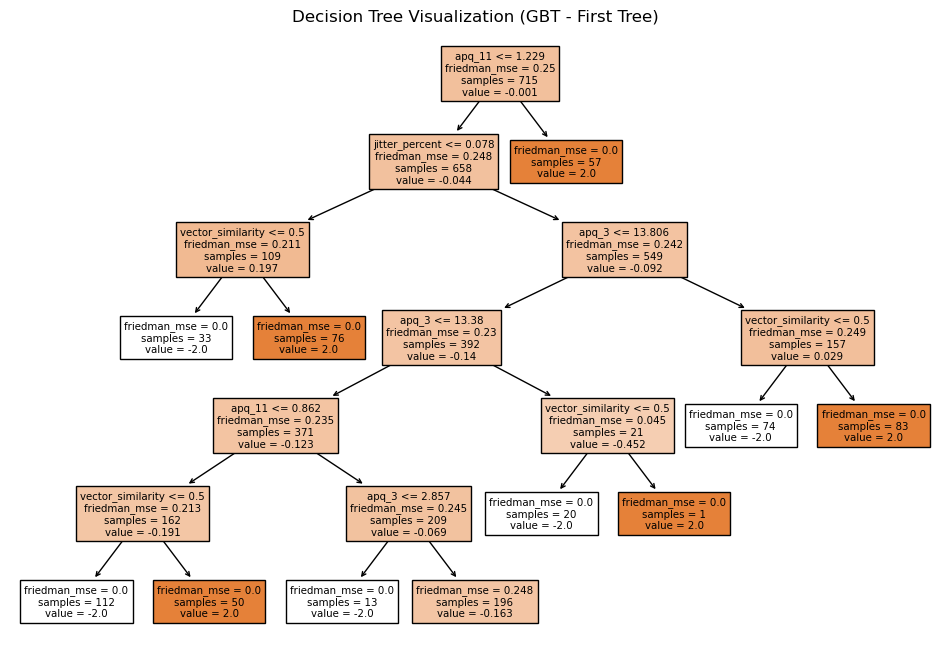

In [38]:
from sklearn.tree import plot_tree

tree_to_visualize = best_gbt.estimators_[0][0]  # Access the first tree

# Plot the decision tree
plt.figure(figsize=(12, 8))
# White box indicating healthy prediction at each bottom leaf node, Parkinson's Disease otherwise
plot_tree(tree_to_visualize, filled=True, feature_names=train_features.columns, class_names=['Healthy', 'Parkinson\'s Disease'])
plt.title('Decision Tree Visualization (GBT - First Tree)')
plt.show()

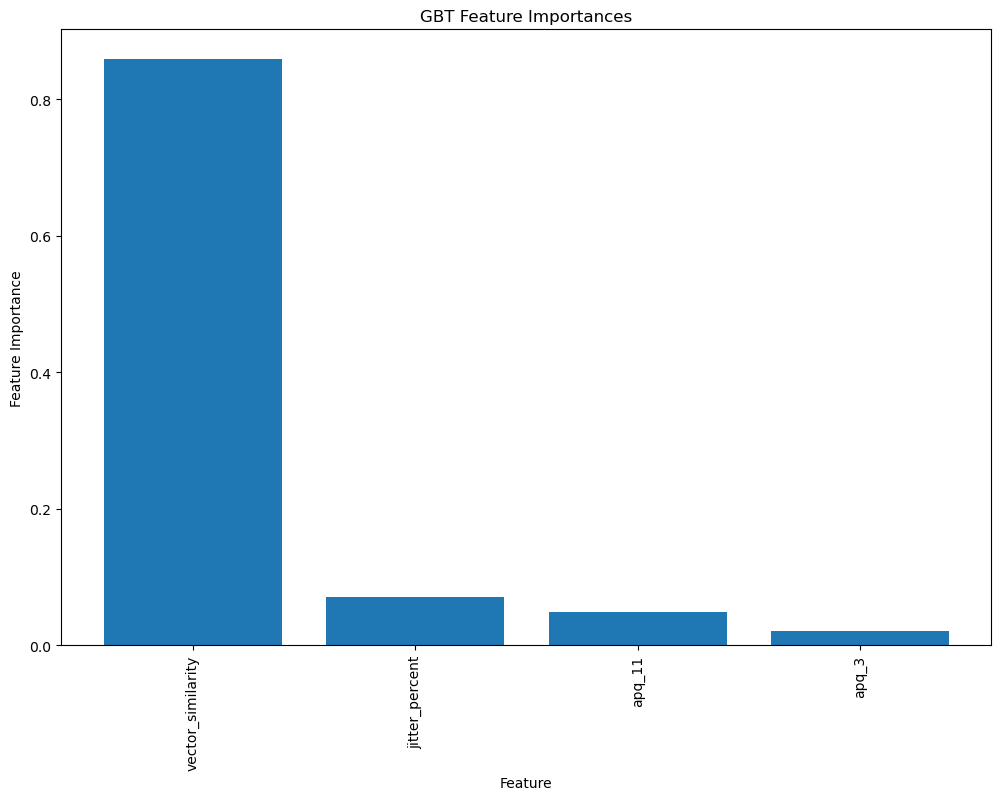

In [39]:
feature_importances = best_gbt.feature_importances_

# Get the names of the features
feature_names = train_features.columns

# Sort the features by importance in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot feature importances as a bar chart
plt.figure(figsize=(12, 8))
plt.bar(range(train_features.shape[1]), feature_importances[sorted_idx], align="center")
plt.xticks(range(train_features.shape[1]), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("GBT Feature Importances")
plt.show()

### Insights on predictive performance on the (unseen) test set

The initial set of metrics (from the [PR no. 2](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/2)) of a Random Forest (RF) model, using 
80% and 20% of the data split randomly between the train and test sets but without training the model via cross-validation, was as follows:
- Test set accuracy = 0.709
- Test set weighted precision = 0.71
- Test set weighted recall = 0.71
- Test set weighted F-measure = 0.71

The second set of metrics (from the [PR no. 3](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/3)) of a RF model, using the previously generated data splits to avoid time- and subject-related data leakage (2008-2016 data for training, 2018 data on different subjects for testing) but without training the model via cross-validation, was as follows:
- Test set accuracy = 0.75
- Test set weighted precision = 0.71
- Test set weighted recall = 0.75
- Test set weighted F-measure = 0.69

The third set of metrics (from the [PR no. 4](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/4)) of a RF model, using the previously generated data splits to avoid time- and subject-related data leakage (2008-2016 data for training, 2018 data on different subjects for testing) but training the model with cross-validation, was as follows:
- Test set accuracy = 0.75
- Test set weighted precision = 0.81
- Test set weighted recall = 0.75
- Test set weighted F-measure = 0.65

The fourth set of metrics (from the [PR no. 5](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/5)) of a Gradient-Boosted Tree (GBT) model, using the previously generated data splits to avoid time- and subject-related data leakage (2008-2016 data for training, 2018 data on different subjects for testing) but training the model with cross-validation, was as follows:
- Test set accuracy = 0.76
- Test set weighted precision = 0.74
- Test set weighted recall = 0.76
- Test set weighted F-measure = 0.70

I.e., the following predictive performance changes have been achieved between the third (RF) and fourth (GBT) set of metrics:
- Increased accuracy by 1.2%
- Decreased weighted precision by 7.6%
- Increased weighted recall by 1.2%
- Increased weighted F-measure by 5.3%

Thus, overall and considering that the weighted recall is the key metric to increase in this project, the predictive performance of the GBT model was found slightly higher than the RF and the Decision Tree models. Thus, the GBT model was selected as the optimal one for this project.

In the notebook from the [PR no. 6](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/6), multi-collinear features were identified and discarded, thus leading to retain the top three predictors for model training, i.e., apq_11, apq_3, jitter_percent. Furthermore, outliers were detected and removed via the z-scores-based method. The final GBT model's predictive performance on the test set was as follows, which is slightly higher than its training performance, indicating a promising generalisation on unseen data: 
- Test set accuracy = 0.79, 3.3% higher than the previous version
- Test set weighted precision = 0.83, 10.1% higher than the previous version
- Test set weighted recall = 0.79, 3.3% higher than the previous version
- Test set weighted F-measure = 0.71, 1.9% higher than the previous version

In this notebook, leveraging vector similarity via the nearest neighbour algorithm yielded the following slightly higher predictive performance metrics:
- Test set accuracy = 0.79, as the previous version
- Test set weighted precision = 0.84, 1% higher than the previous version
- Test set weighted recall = 0.79, as the previous version
- Test set weighted F-measure = 0.72, 1% higher than the previous version

In [29]:
# session.execute("""drop table speech_data""")